In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from keras_tuner import Hyperband

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [3]:
print("Train shape: ", tweets.shape)
print("Test shape ", test_data.shape)

Train shape:  (7613, 5)
Test shape  (3263, 4)


In [4]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Vamos a comprobar la cantidad de valores nulos que tenemos por columna

In [5]:
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

## Análisis exploratorio

Vamos a ver cuantos valores tenemos de desastres y no desastres

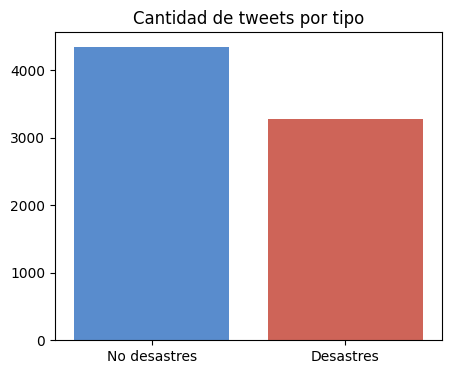

In [6]:
plt.figure(figsize=(5,4))
# Define la paleta de colores
palette_desastres = {0: '#4689E0', 1: '#E15445'}
categories = {0: 'No desastres', 1: 'Desastres'}

plot = sns.countplot(x = 'target', data = tweets, hue='target', palette = palette_desastres, legend=False)
plot.set_ylabel('')
plot.set_xlabel('')
plot.set_title("Cantidad de tweets por tipo")
plt.xticks(ticks=sorted(categories.keys()), labels=categories.values())
plt.show()

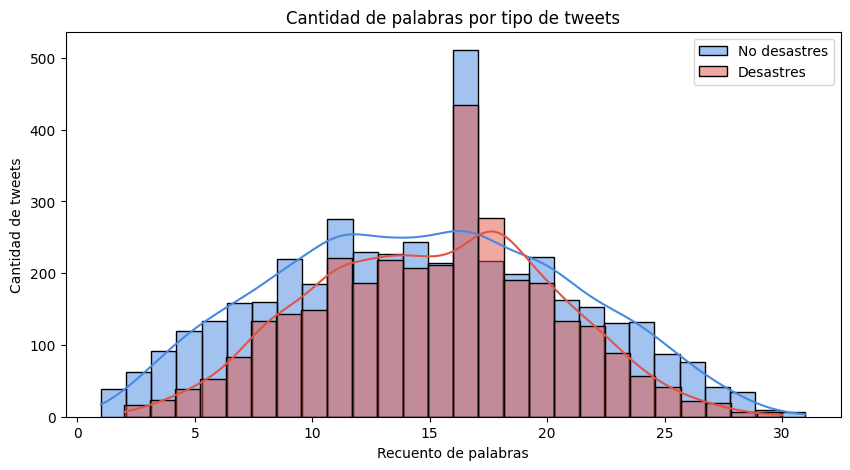

In [7]:
tweets['Count of Words'] = tweets['text'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(tweets[tweets['target']==0]['Count of Words'], label = "No desastres",kde=True, color=palette_desastres[0])
sns.histplot(tweets[tweets['target']==1]['Count of Words'], label = "Desastres",kde=True, color=palette_desastres[1])

plt.xlabel('Recuento de palabras')
plt.ylabel('Cantidad de tweets')
plt.title('Cantidad de palabras por tipo de tweets')
plt.legend()
plt.show()

Podemos observar que se distribuyen de una manera bastante similar sin diferencias significativas

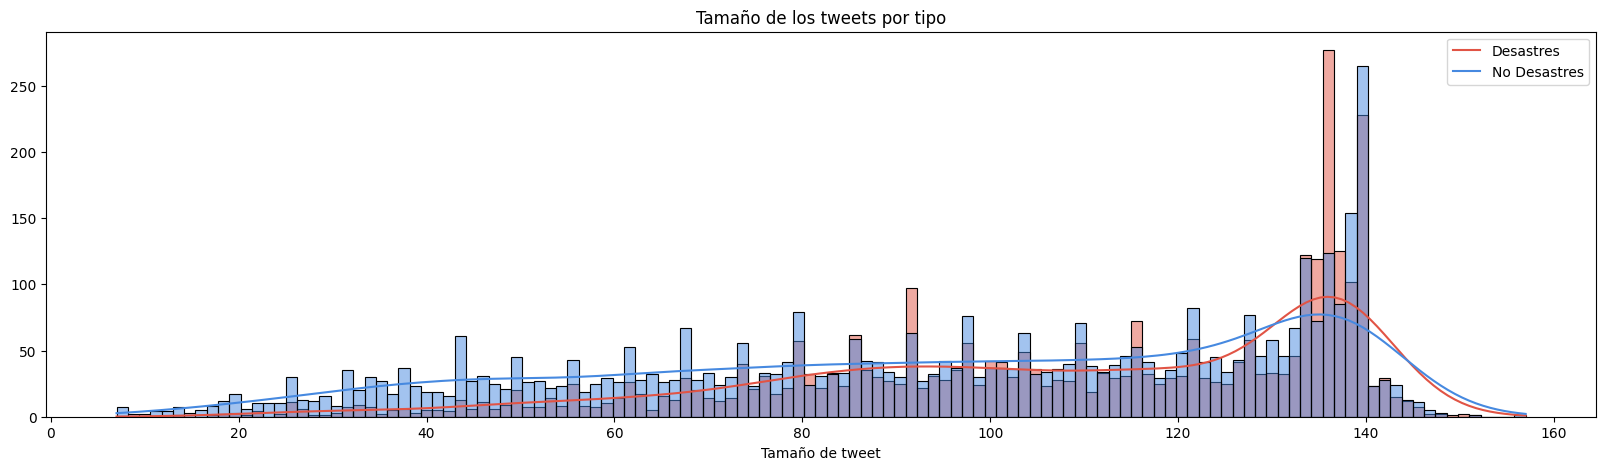

In [8]:
tweets['Length of Tweet'] = tweets['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize = (20, 5))
sns.histplot(x = 'Length of Tweet', data=tweets, hue="target", bins=125, kde= True,palette=palette_desastres)

plt.xlabel("Tamaño de tweet")
plt.ylabel("")
plt.title('Tamaño de los tweets por tipo')
plt.legend(labels=['Desastres', 'No Desastres'])
plt.show()

Como observamos en las palabras, se mantiene una distribución similar en la cantidad. Destacando que la media de tweets tienen alrededor de 140 palabras

In [9]:
#* Agrupamos las palabras para realizar un conteo de las mismas
keyword = tweets.groupby('keyword')['target'].count()
df_palabras = pd.DataFrame({'palabras_clave':keyword.index,'total':keyword.values}).sort_values(by='total',ascending=False)
df_palabras.head()

,palabras_clave,total
104,fatalities,45
63,deluge,42
8,armageddon,42
177,sinking,41
57,damage,41


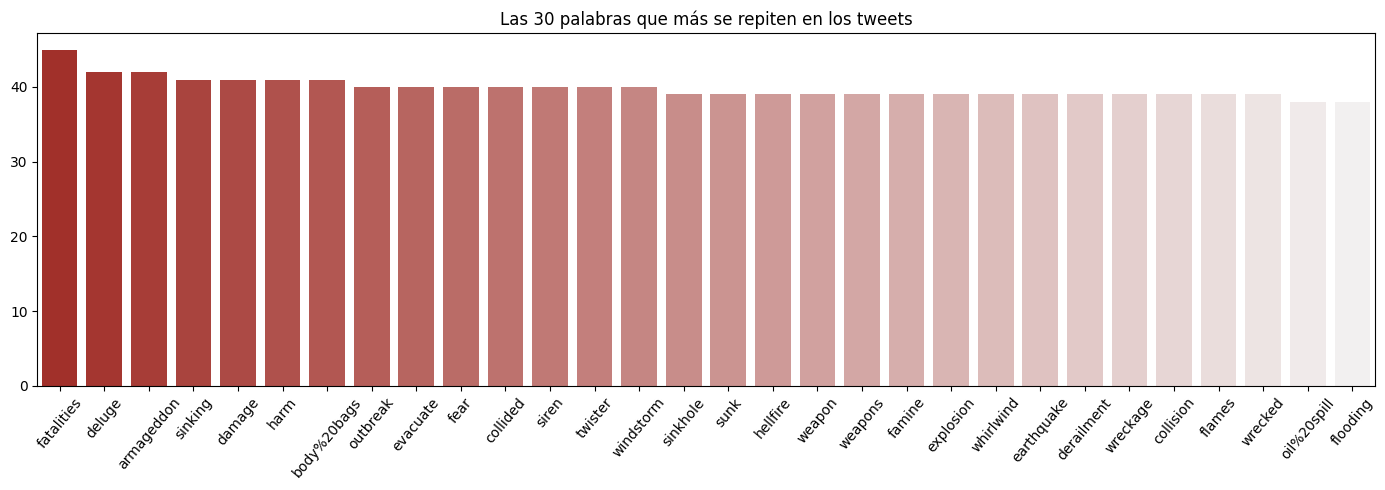

In [10]:
palette_palabras = reversed(sns.light_palette('#b51e16', n_colors=30)) 

plt.figure(figsize=(14,5))
# sns.barplot(data=df_palabras.head(30),x='palabras_clave',y='total',hue='palabras_clave', palette=palette_palabras)
sns.barplot(data=df_palabras.head(30),x='palabras_clave',y='total',hue='palabras_clave', palette=palette_palabras)
plt.xticks(rotation = 50)
plt.xlabel("")
plt.ylabel("")
plt.title('Las 30 palabras que más se repiten en los tweets')
plt.tight_layout()
plt.show()

Como podemos observar, todas guardan relación con algún tipo de catástrofe 

In [11]:
#* Ahora, vamos a agrupar por ciudad para ver cuantos tweets tiene cada una
location = tweets.groupby('location')['target'].count()
df_loc = pd.DataFrame({'poblacion':location.index,'total':location.values}).sort_values(by='total',ascending=False)
df_loc.head()

,poblacion,total
2643,USA,104
1826,New York,71
2662,United States,50
1506,London,45
587,Canada,29


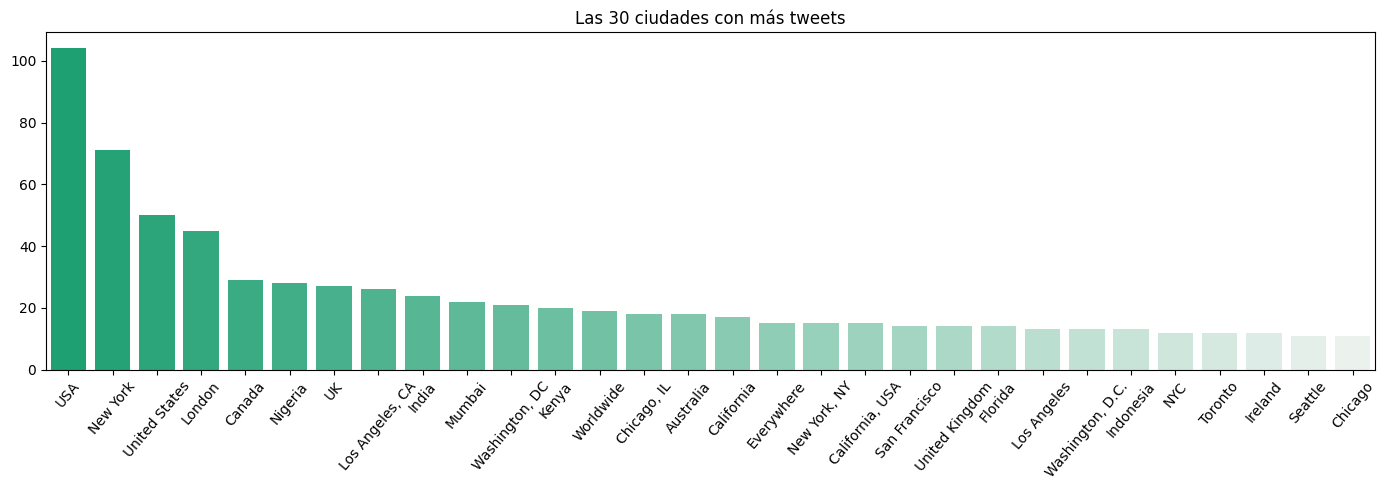

In [12]:
palette_poblacion = reversed(sns.light_palette('#09b579', n_colors=30)) 

plt.figure(figsize=(14,5))
sns.barplot(data=df_loc.head(30),x='poblacion',y='total',hue='poblacion',palette=palette_poblacion)
plt.xticks(rotation = 50)
plt.xlabel("")
plt.ylabel("")
plt.title('Las 30 ciudades con más tweets')
plt.tight_layout()
plt.show()

Podemos observar, que la mayoría de los tweets se concentran en Estados Unidos

## Preprocesamiento

### Creamos unas funciones para eliminar las caracteres no relevantes

In [13]:
def remove_URL(text):
    """Elimina las urls de un texto"""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    """Elimina las etiquetas html de un texto"""
    html=re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    """Elimina los emojis y signos extraños de un texto"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  #* Emoticonos
                           u"\U0001F300-\U0001F5FF"  #* Símbolos y pictogramas
                           u"\U0001F680-\U0001F6FF"  #* Símbolos de mapas y transportes
                           u"\U0001F1E0-\U0001F1FF"  #* Banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    """Elimina los signos de puntuación"""
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

lem = WordNetLemmatizer()
def lemmatize_words(text):
    text = ' '.join(lem.lemmatize(word) for word in text.split(' '))
    return text

def remove_stopwords(text):
    """Elimina las palabras comunes del ingles"""
    palabras_extra = ["the","new","im","amp","û","u","ha","via","news","wa"]
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(palabras_extra)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [14]:
tweets['text'] = tweets['text'].apply(lambda x : remove_URL(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_html(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_emoji(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_punct(x))
tweets['text'] = tweets['text'].apply(lambda x : x.lower())
tweets['text'] = tweets['text'].apply(lambda x : lemmatize_words(x))
tweets['text'] = tweets['text'].apply(lambda x : remove_stopwords(x))

test_data['text'] = test_data['text'].apply(lambda x : remove_URL(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_html(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_emoji(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_punct(x))
test_data['text'] = test_data['text'].apply(lambda x : x.lower())
test_data['text'] = test_data['text'].apply(lambda x : lemmatize_words(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))

In [ ]:
#* Comprobamos que se haya eliminado
tweets.head()

In [ ]:
plt.figure(figsize=(10,5))
word_cloud = WordCloud(background_color = 'black').generate(" ".join(tweets[tweets['target']==0]['text']))
plt.imshow(word_cloud)
plt.axis("off")
plt.title("Nube de palabras de no desastres")
plt.show()  

In [ ]:
plt.figure(figsize=(10,5))
word_cloud = WordCloud(background_color = 'black').generate(" ".join(tweets[tweets['target']==1]['text']))
plt.imshow(word_cloud)
plt.axis("off")
plt.title("WordCloud For Disaster Tweets")
plt.show()  

# Modelo

In [ ]:
X_train = tweets["text"]
y_train = tweets["target"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15, random_state=42)

In [ ]:
def build_model(hp):  # Función de hiperparámetro para ajustar
  num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Ajustar el número de capas
  units = hp.Int('units', min_value=4, max_value=32, step=4)  # Ajustar las unidades por capa
  dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.8)  # Tune dropout rate

  model = keras.Sequential()
  for _ in range(num_layers):
    model.add(layers.Dense(units, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(1, activation='sigmoid'))

  # Compilación del modelo con tasa de aprendizaje ajustable
  optimizer = keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

In [ ]:
# Crear el vectorizador TF-IDF (fuera del tuner para mayor eficiencia)
vectorizer = TfidfVectorizer()  # Ajustar el tamaño del vocabulario según sea necesario

# Preparar los datos de entrenamiento y validación vectorizados TF-IDF
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# # Definir el tuner (elegir Hyperband o RandomSearch)
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    project_name='model_tuning',
    directory='C:/Users/Alejandro/Downloads',
    tune_new_entries=True
)

# Iniciar el proceso de ajuste
tuner.search(X_train_vec, y_train, epochs=20, validation_data=(X_test_vec, y_test))

# Obtener el mejor modelo
best_model = tuner.get_best_models()[0]

# Evaluar el mejor modelo en los datos de prueba (ya vectorizados TF-IDF)
loss, accuracy = best_model.evaluate(X_test_vec, y_test)
print(f"Pérdida de prueba: {loss:.4f}, Precisión de prueba: {accuracy:.4f}")

# Guardar el mejor modelo (opcional)
best_model.save('best_model.h5')


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history = best_model.fit(X_train_vec, y_train, epochs=50, validation_data=(X_test_vec, y_test),
          batch_size=64, callbacks=[early_stopping])

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy',"loss","val_loss"]].plot(figsize=(10, 7))
plt.grid(True)
plt.ylim(0.1, None) 
plt.xlabel("epochs")
plt.show()

Como podemos observar, el modelo tiende rápidamente al sobreentrenamiento, para corregirlo hemos añadido una capa de Dropout y muy pocas épocas, ya que hay muy pocos datos

# Validación

In [ ]:
X_val_vec = vectorizer.transform(test_data["text"])

predicciones = best_model.predict(X_val_vec)
predicciones = np.where(predicciones > 0.5, 1, 0)

In [ ]:
test_data["predicciones"] = predicciones
test_data[['text','predicciones']].head(20)

### Podemos observar, que el modelo predice correctamente los tweets del test